In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2
import cv2
import os
from sklearn.exceptions import ConvergenceWarning

train_labels = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-jan-2024/train.csv")
sample = pd.read_csv('/kaggle/input/extracting-attributes-from-fashion-images-jan-2024/sample_submission.csv')

train_path = "/kaggle/input/extracting-attributes-from-fashion-images-jan-2024/train"
test_path = "/kaggle/input/extracting-attributes-from-fashion-images-jan-2024/test"

import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


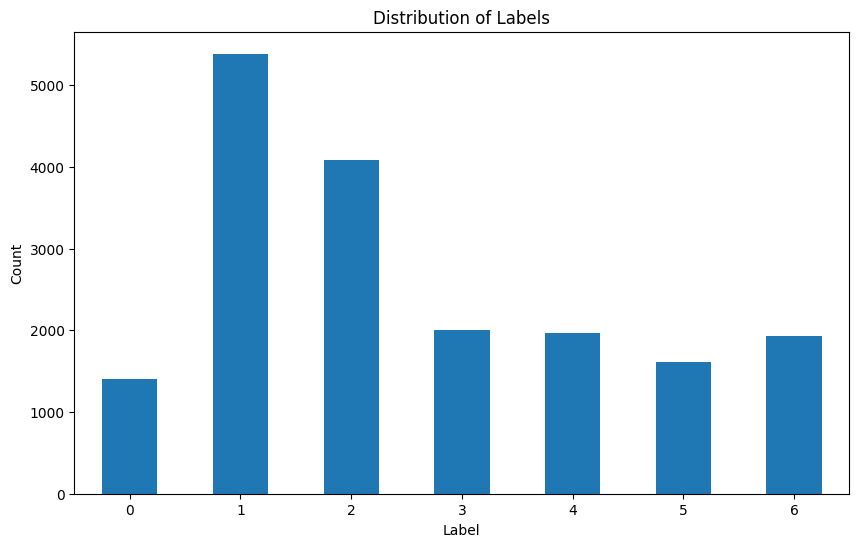

In [2]:
plt.figure(figsize=(10, 6))
train_labels['label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=0)
plt.show()

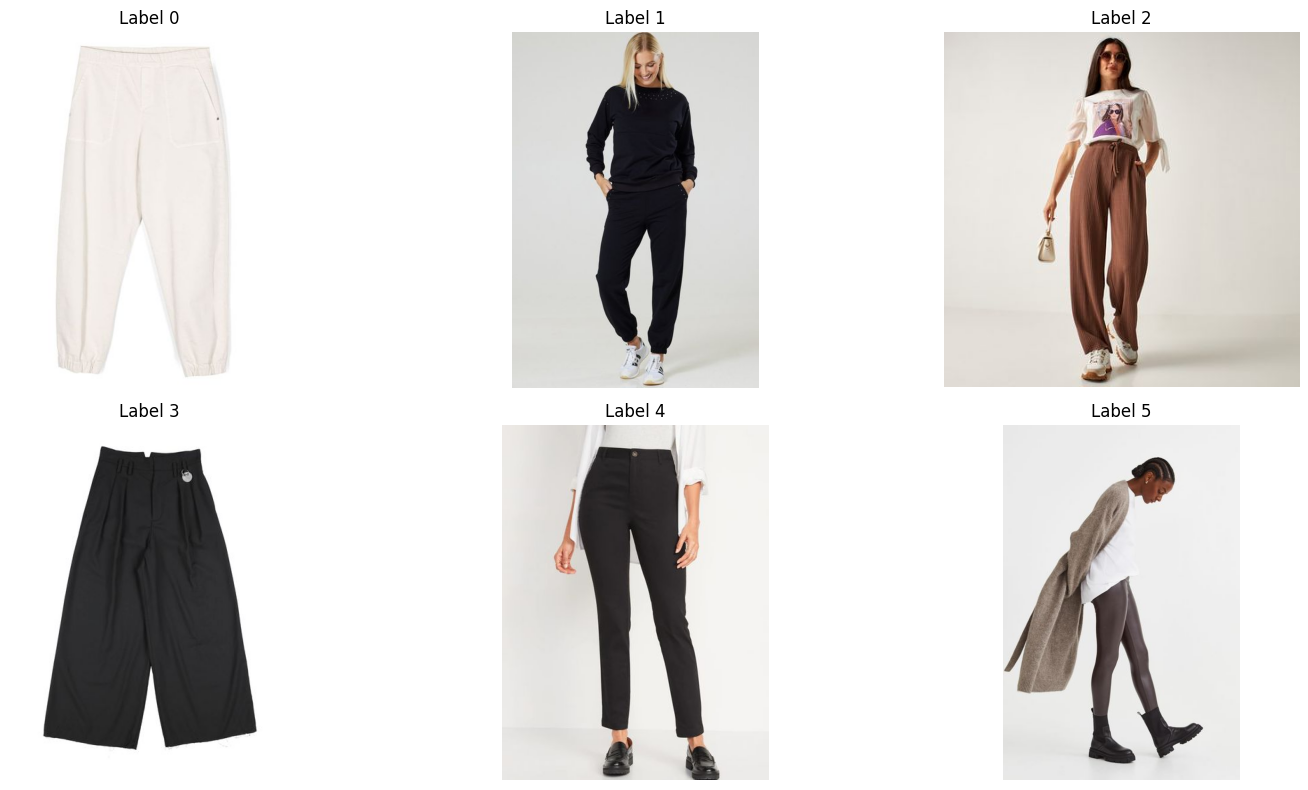

In [3]:
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(train_labels['label'].unique()):
        ax.axis("off")
        continue

    df_subset = train_labels[train_labels['label'] == i]
    img_path = os.path.join(train_path, df_subset['file_name'].values[0])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img_rgb)
    ax.set_title(f"Label {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [4]:
train_labels['label'] = train_labels['label'].astype(str)

gen  = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2,
)

batch_size = 32
img_width, img_height = 224, 224

train_generator = gen.flow_from_dataframe(
    train_labels,
    directory=train_path,
    x_col='file_name',
    y_col='label',
    subset="training",
    color_mode="rgb",
    target_size=(img_width, img_height),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

validation_generator = gen.flow_from_dataframe(
    train_labels,
    directory=train_path,
    x_col='file_name',
    y_col='label',
    subset="validation",
    color_mode="rgb",
    target_size=(img_width, img_height),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

Found 14713 validated image filenames belonging to 7 classes.
Found 3678 validated image filenames belonging to 7 classes.


In [5]:
from tensorflow.keras.layers import BatchNormalization

img_width, img_height = 224, 224
base_model = MobileNetV2(
    include_top=False,
   weights='imagenet',
    input_shape=(img_width, img_height, 3) )

'''base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)#'''

base_model.trainable = True


model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2*2048, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
)

accuracy_score = model.evaluate(validation_generator)
print("Validation Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
459/459 [==============================] - ETA: 0s - loss: 2.3372 - accuracy: 0.1926

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


459/459 [==============================] - 377s 745ms/step - loss: 2.3372 - accuracy: 0.1926 - val_loss: 3.7716 - val_accuracy: 0.0397 - lr: 1.0000e-04
Epoch 2/50
459/459 [==============================] - 281s 613ms/step - loss: 1.8003 - accuracy: 0.3310 - val_loss: 2.3076 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 3/50
459/459 [==============================] - 307s 668ms/step - loss: 1.4131 - accuracy: 0.4876 - val_loss: 2.3690 - val_accuracy: 0.2749 - lr: 1.0000e-04
Epoch 4/50
459/459 [==============================] - 282s 613ms/step - loss: 1.2647 - accuracy: 0.5534 - val_loss: 1.7697 - val_accuracy: 0.3544 - lr: 1.0000e-04
Epoch 5/50
459/459 [==============================] - 280s 610ms/step - loss: 1.1641 - accuracy: 0.5878 - val_loss: 1.6266 - val_accuracy: 0.3522 - lr: 1.0000e-04
Epoch 6/50
459/459 [==============================] - 278s 607ms/step - loss: 1.0849 - accuracy: 0.6060 - val_loss: 1.6100 - val_accuracy: 0.3775 - lr: 1.0000e-04
Epoch 7/50
459/459 [=============

In [6]:
best_model = load_model('/kaggle/working/best_model.h5')

In [7]:
predictions = []
for image in sample.file_name:
  img = tf.keras.preprocessing.image.load_img(test_path + '/' + image)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.image.resize(img, (img_width, img_height))
  img = tf.reshape(img, (-1, img_width, img_height, 3))
  prediction = best_model.predict(img / 255)
  predictions.append(np.argmax(prediction))

my_submission = pd.DataFrame({'file_name': sample.file_name, 'label': predictions})
my_submission.to_csv('submission_new.csv', index=False)

1/1 [==============================] - 0s 23ms/step


In [8]:
AAAAAAAAAAAAAbbbbaaAAAAbAaAaasaaAAAAAAAA

NameError: name 'AAAAAAAAAAAAAbbbbaaAAAAbAaAaasaaAAAAAAAA' is not defined